In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

from JINAPyCEE import gamma

import caga; reload(caga); reload(caga.plot); reload(caga.calc);

In [3]:
gt = caga.gamma_tree.load("H1725272_LX11/rsid686.npy")
#gt = caga.gamma_tree.load("H1725272_LX11/rsid23.npy")

In [4]:
kw = gt.kwargs

In [5]:
np.log10(gt.m_DM_0)

12.067528837481948

In [6]:
np.log10(gt.Mpeak)

12.067528837481948

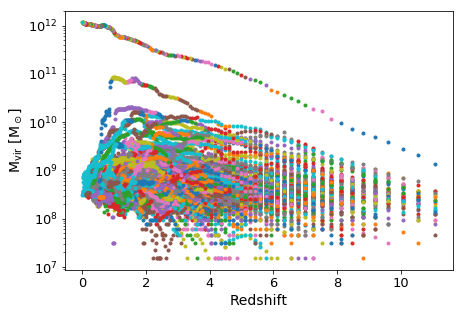

In [7]:
fig = gt.plot_mass_history()

In [8]:
SSPs_in = caga.precompute_ssps(main_table="K10K06",
                               imf_yields_range=[1,50],
                               nb_1a_per_m=1e-3)
kwargs = caga.generate_kwargs(gt, 1e7, SSPs_in=SSPs_in)
assert kwargs["pre_calculate_SSPs"]

OMEGA run in progress..
SYGMA run in progress..
   SYGMA run completed - Run time: 0.07s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.04s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.04s
Warning -- Not enough gas to sustain the SFH. 2
   OMEGA run completed - Run time: 2.24s


In [9]:
# Run GAMMA
kwargs["sfe"] = 0.005
kwargs["print_off"] = True
g = gamma.gamma(**kwargs)

GAMMA run in progress..
   GAMMA run completed - Run time: 8.47s


In [10]:
reload(caga); reload(caga.plot); reload(caga.calc); reload(caga.plot.calc); reload(caga.plot.caga);

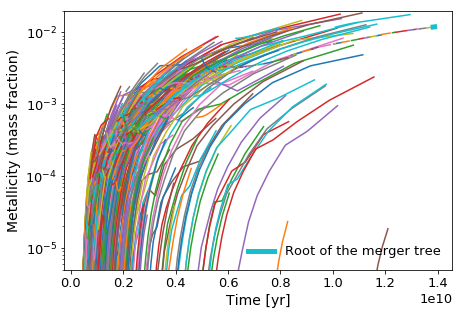

In [11]:
fig = caga.plot.metallicity_evolution(g,tree_trunk_ID=gt.tree_trunk_ID)

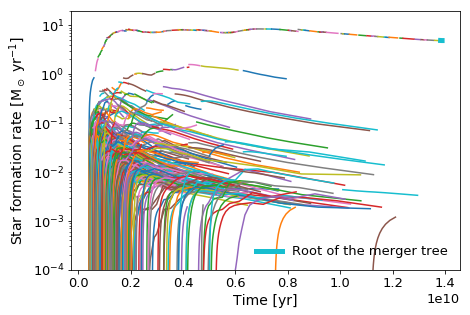

In [12]:
fig = caga.plot.sfh_evolution(g,tree_trunk_ID=gt.tree_trunk_ID)

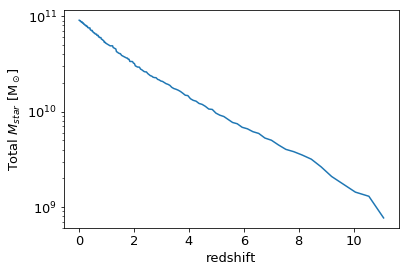

In [13]:
fig = caga.plot.mstar_evolution(g,reduction_factor=0.7)

/Users/alexji/Dropbox/caterpillar/NuPyCEE/caga/caga/calc.py:54: RuntimeWarning: divide by zero encountered in log10
  Fe_H.append( np.log10(m_Fe_H_ratio) - np.log10((10**(7.50-12))*56.0) )


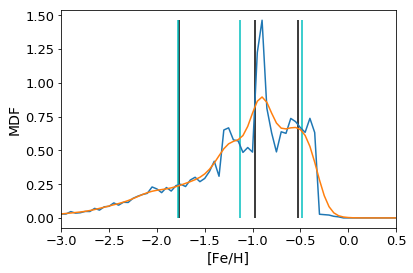

In [14]:
fig, (mdf_x, mdf_y, mdf_gauss_y) = caga.plot.metallicity_distribution(g, sigma_gauss=0.1)
lines = caga.find_distribution_percentile(mdf_x,mdf_gauss_y,[.5-.68/2,.5,.5+.68/2])
plt.vlines(lines,0,np.max(mdf_y),color='k')
mean = caga.find_distribution_mean(mdf_x,mdf_gauss_y)
std = caga.find_distribution_std(mdf_x,mdf_gauss_y)
plt.vlines([mean+_x for _x in [-std, 0, std]],0,np.max(mdf_y),color='c')


# Sampling stars from one OMEGA+ branch

In [15]:
reload(caga.sample);

In [16]:
z_index = 0
om = g.galaxy_inst[z_index][0].inner

In [17]:
%%time
np.random.seed(3498756)
samples = caga.sample.sample_omega(om, 10000, t0=g.times[z_index])

CPU times: user 4.75 ms, sys: 3.49 ms, total: 8.23 ms
Wall time: 4.82 ms


/Users/alexji/Dropbox/caterpillar/NuPyCEE/caga/caga/caga.py:69: RuntimeWarning: divide by zero encountered in log10
  return np.log10(NH) - solar + 12


Text(0.5,0,'t_form (Gyr)')

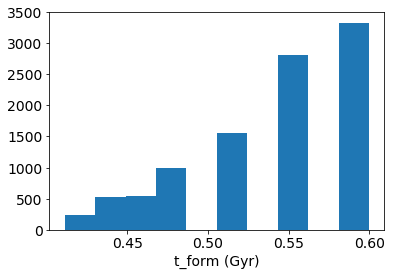

In [18]:
plt.hist(samples[:,0]/1e9)
plt.xlabel("t_form (Gyr)")

Text(0.5,0,'[C/H]')

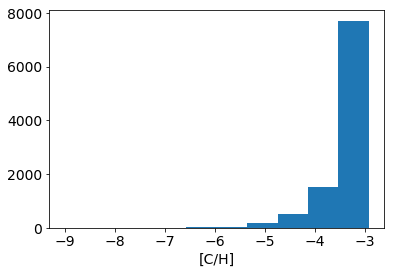

In [19]:
CH = caga.sample.fill_nonfinite(samples[:,caga.sample.default_elems.index("C")+1],-9)
MgH= caga.sample.fill_nonfinite(samples[:,caga.sample.default_elems.index("Mg")+1],-9)
plt.hist(CH)
plt.xlabel("[C/H]")

Text(0.5,0,'[Fe/H]')

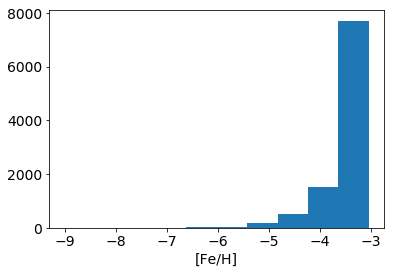

In [20]:
FeH = caga.sample.fill_nonfinite(samples[:,caga.sample.default_elems.index("Fe")+1],-9)
plt.hist(FeH)
plt.xlabel("[Fe/H]")

Text(0,0.5,'[C/Fe]')

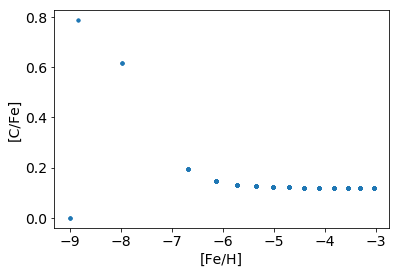

In [21]:
plt.plot(FeH, CH-FeH, '.')
plt.xlabel("[Fe/H]")
plt.ylabel("[C/Fe]")

Text(0,0.5,'[Mg/Fe]')

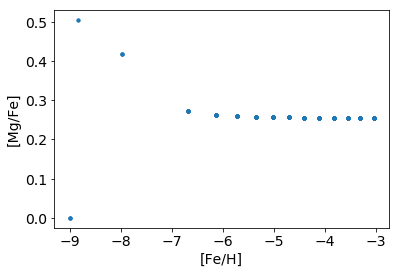

In [22]:
plt.plot(FeH,MgH-FeH,'.')
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")

# Sampling stars from whole GAMMA tree

Warning: it does not seem like these yields are good, and something is really weird with the [alpha/Fe] evolution!

In [23]:
%%time
samples = caga.sample.sample_gamma(g,1000000)

/Users/alexji/Dropbox/caterpillar/NuPyCEE/caga/caga/caga.py:69: RuntimeWarning: divide by zero encountered in log10
  return np.log10(NH) - solar + 12


CPU times: user 652 ms, sys: 141 ms, total: 793 ms
Wall time: 796 ms


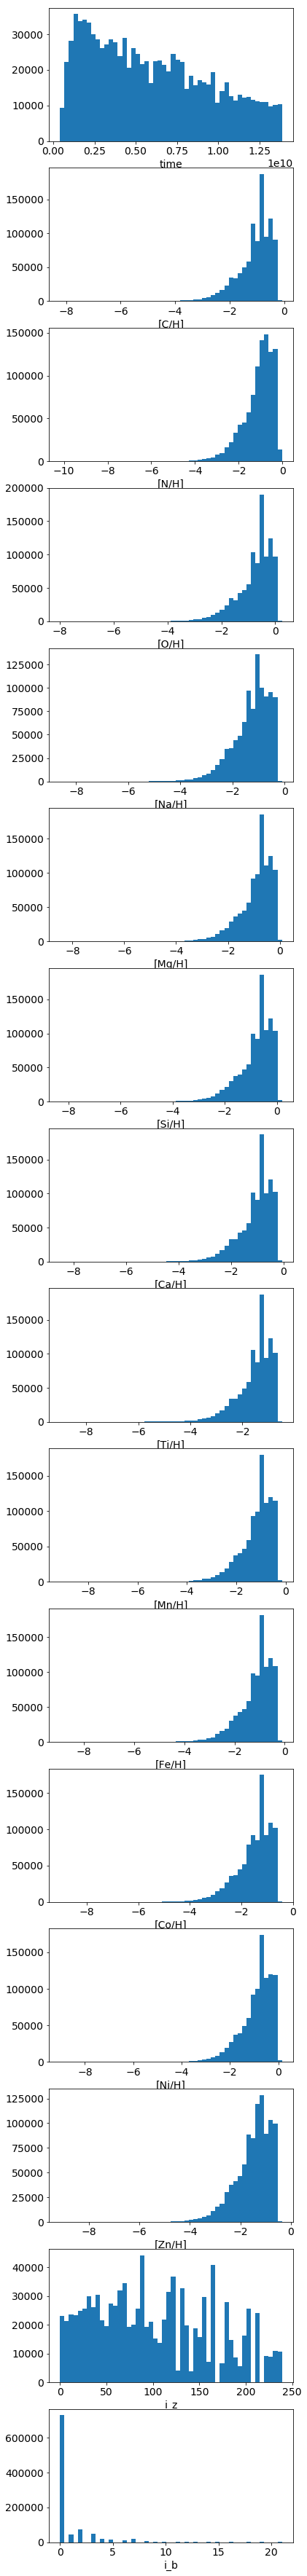

In [24]:
cols = ["time"] + ["[{}/H]".format(el) for el in caga.sample.default_elems] + ["i_z","i_b"]
assert len(cols) == samples.shape[1]
fig, axes = plt.subplots(len(cols), figsize=(6,4*len(cols)))
for j,(col,ax) in enumerate(zip(cols,axes)):
    x = caga.sample.drop_nonfinite(samples[:,j])
    ax.hist(x,bins=50)
    ax.set_xlabel(col)

Here we plot [Fe/H] vs [alpha/Fe] sampled from the data.

/Users/alexji/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """


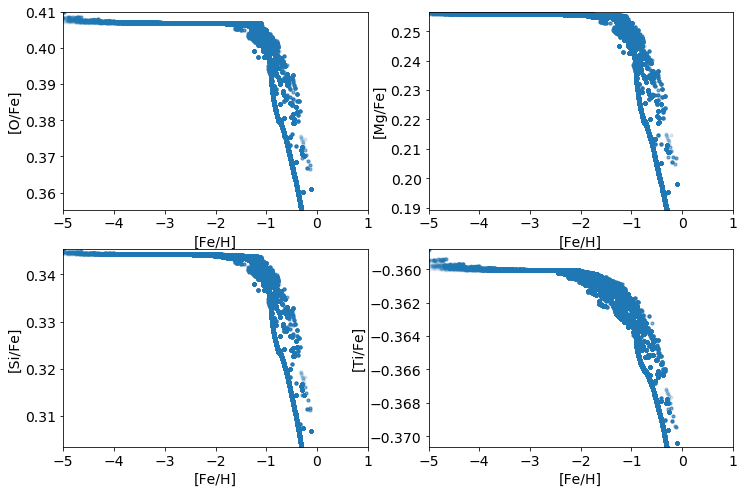

In [25]:
j_Fe = caga.sample.default_elems.index("Fe")+1
alphaelems = ["O","Mg","Si","Ti"]
j_alpha = [caga.sample.default_elems.index(elem)+1 for elem in alphaelems]
FeH = samples[:,j_Fe]
alphaFes = [samples[:,j_x] - FeH for j_x in j_alpha]
fig, axes = plt.subplots(2,2,figsize=(12,8))
for ax, elem, alphaFe in zip(axes.flat, alphaelems, alphaFes):
    ax.plot(FeH,alphaFe,'.',alpha=.05)
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[{}/Fe]'.format(elem))
    ax.set_xlim(-5,1)
    ii = (FeH > -5) & (FeH < 1)
    ymin, ymax = np.min(alphaFe[ii]), np.max(alphaFe[ii])
    ax.set_ylim(ymin,ymax)

Can also make a contour plot.

See `plt.contour?` and `np.histogram2d` for keywords that can be passed to `caga.plot.contour`

This automatically determines contour levels based on percentiles you can pass in.

/Users/alexji/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/alexji/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/alexji/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


Text(0,0.5,'[Mg/Fe]')

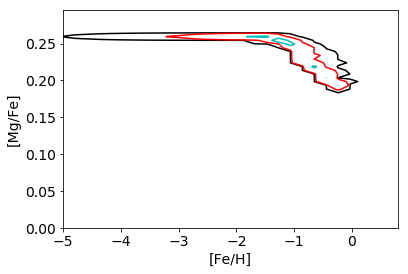

In [26]:
xbins, ybins = np.arange(-5,1,.2), np.arange(0.0, 0.3, .005) #np.arange(-0.55,-0.34,.01)
fig = caga.plot.contour(FeH,alphaFes[1],bins=[xbins,ybins],colors=['k','r','c'],percentiles=[10,50,90])
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")